# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "[**MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles**](https://arxiv.org/pdf/2105.13289.pdf)" accepted in IEEE Internet of Things Journal.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, and A. Shami, “MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles,” IEEE Internet of Things Journal, vol. 9, no. 1, pp. 616-632, Jan.1, 2022.

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [3]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [21] if you work on the sampled dataset. 

In [4]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [5]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [6]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [7]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [8]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [9]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

In [10]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [11]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [12]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [13]:
df_major['klabel'].value_counts()

klabel
809    503
20     482
264    348
324    337
739    334
      ... 
964      1
877      1
915      1
586      1
71       1
Name: count, Length: 979, dtype: int64

In [14]:
cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [15]:
df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,398,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,191,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,359,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,237,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,690,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,560,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,710,3


In [16]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [17]:
result['Label'].value_counts()

Label
0    122
3    120
5     59
2     20
Name: count, dtype: int64

In [18]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
47365,1.775221,0.037025,0.008402,-0.017914,0.057771,0.265490,-0.211174,0.003417,0.284779,1.528310,...,-0.108548,-0.081786,-0.127563,-0.093409,2.170254,-0.137651,2.093023,2.205931,2,3
26307,-0.528462,-0.068426,-0.051737,-0.030840,-0.046531,-0.193358,0.561979,-0.035356,-0.255104,-0.524030,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,8,0
5239,-0.483254,-0.050851,-0.021667,-0.033088,0.057881,-0.218767,-0.211174,-0.198110,-0.209439,3.620304,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
2710,-0.366345,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.107183,-0.081786,-0.126487,-0.091931,-0.273554,-0.137651,-0.286162,-0.255544,11,3
207,-0.499758,-0.033276,-0.081806,-0.033182,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50878,2.195125,0.037025,0.008402,-0.019038,0.057771,0.238587,-0.211174,-0.013815,0.257731,1.528310,...,-0.107176,-0.081786,-0.126482,-0.091924,2.652493,-0.137651,2.562511,2.691657,983,3
52644,-0.528422,-0.015701,-0.081806,-0.034306,-0.048343,-0.248659,-0.211174,-0.247894,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,987,3
37188,-0.486442,0.037025,-0.021667,0.004051,-0.045689,0.512103,-0.211174,0.340174,0.552795,-0.507446,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,994,0
32602,-0.527632,-0.086001,-0.066771,-0.032199,-0.047181,-0.181401,0.729147,0.010598,-0.255104,-0.513936,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,996,0


In [19]:
result = result.drop(['klabel'],axis=1)
# result = result.append(df_minor)
result = pd.concat([result, pd.DataFrame(df_minor)])

In [20]:
result.to_csv('./data/CICIDS2017_sample_km.csv',index=0)

### split train set and test set

In [21]:
# Read the sampled dataset
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [22]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [24]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [25]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [26]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [27]:
X_fs = df[fs].values

In [28]:
X_fs.shape

(4503, 42)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [29]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [30]:
X_fss = fcbf.fit_transform(X_fs,y)

In [31]:
X_fss.shape

(4503, 20)

### Re-split train & test sets after feature selection

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [33]:
X_train.shape

(3602, 20)

In [34]:
pd.Series(y_train).value_counts()

6    1744
1    1573
0      97
3      96
5      47
4      29
2      16
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [35]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [36]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [37]:
pd.Series(y_train).value_counts()

6    1744
1    1573
2    1000
4    1000
0      97
3      96
5      47
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9900110987791343
Precision of XGBoost: 0.9917712826515388
Recall of XGBoost: 0.9900110987791343
F1-score of XGBoost: 0.9894358794726855
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        25
           1       0.99      1.00      1.00       393
           2       0.67      1.00      0.80         4
           3       1.00      1.00      1.00        24
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.91      0.95      0.91       901
weighted avg       0.99      0.99      0.99       901



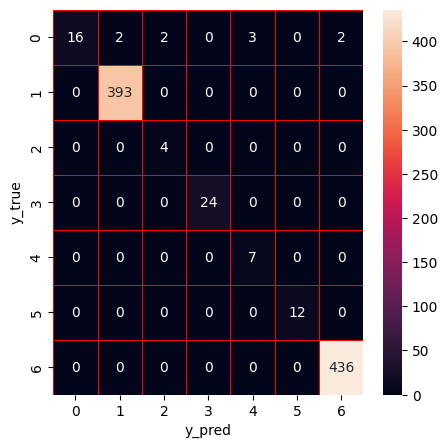

In [38]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [39]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:08<00:00,  2.46trial/s, best loss: -0.9966703662597114] 
XGBoost: Hyperopt estimated optimum {'learning_rate': np.float64(0.27412486581830586), 'max_depth': np.float64(21.0), 'n_estimators': np.float64(80.0)}


Accuracy of XGBoost: 0.9966703662597114
Precision of XGBoost: 0.9968192368702457
Recall of XGBoost: 0.9966703662597114
F1-score of XGBoost: 0.9966036370499465
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        25
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        24
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       901
   macro avg       0.98      0.98      0.98       901
weighted avg       1.00      1.00      1.00       901



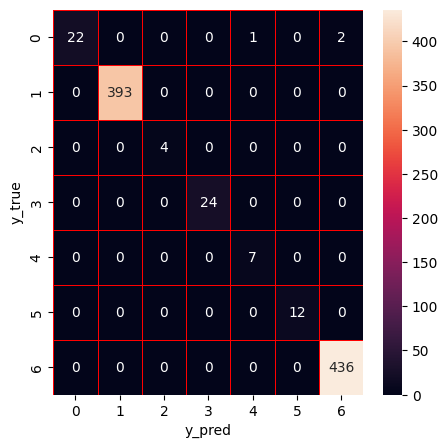

In [40]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [41]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9911209766925638
Precision of RF: 0.9921800317005809
Recall of RF: 0.9911209766925638
F1-score of RF: 0.9907983760529305
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        25
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.96      1.00      0.98        24
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.95      0.96      0.95       901
weighted avg       0.99      0.99      0.99       901



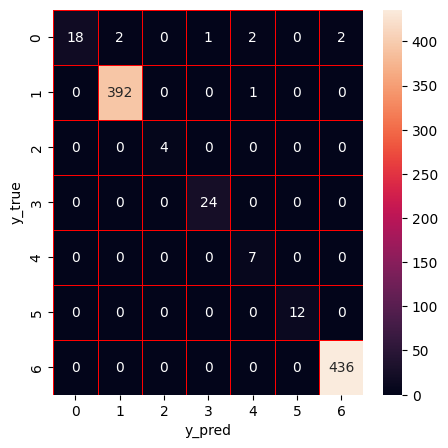

In [42]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [43]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:12<00:00,  1.56trial/s, best loss: -0.9866814650388457]
Random Forest: Hyperopt estimated optimum {'criterion': np.int64(0), 'max_depth': np.float64(27.0), 'max_features': np.float64(9.0), 'min_samples_leaf': np.float64(3.0), 'min_samples_split': np.float64(10.0), 'n_estimators': np.float64(109.0)}


Accuracy of RF: 0.9866814650388457
Precision of RF: 0.9868574759806724
Recall of RF: 0.9866814650388457
F1-score of RF: 0.9859916642233462
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00         4
           3       0.96      0.96      0.96        24
           4       0.70      1.00      0.82         7
           5       1.00      1.00      1.00        12
           6       0.99      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.93      0.94      0.93       901
weighted avg       0.99      0.99      0.99       901



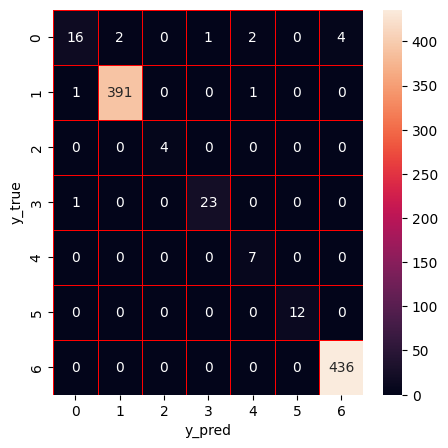

In [44]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [45]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9877913429522752
Precision of DT: 0.9874673767426885
Recall of DT: 0.9877913429522752
F1-score of DT: 0.9869486010598532
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.96      0.96      0.96        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       0.99      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.94      0.94      0.94       901
weighted avg       0.99      0.99      0.99       901



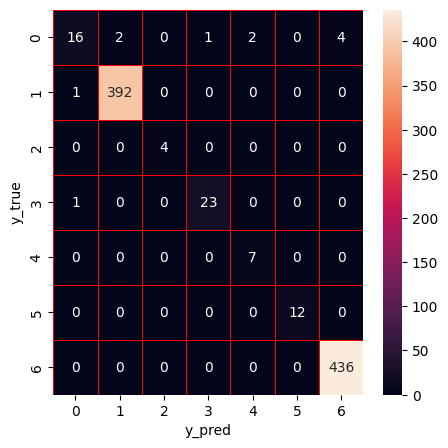

In [46]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [47]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [00:00<00:00, 67.57trial/s, best loss: -0.9922308546059934]
Decision tree: Hyperopt estimated optimum {'criterion': np.int64(0), 'max_depth': np.float64(9.0), 'max_features': np.float64(17.0), 'min_samples_leaf': np.float64(4.0), 'min_samples_split': np.float64(3.0)}


Accuracy of DT: 0.9866814650388457
Precision of DT: 0.9860250275067145
Recall of DT: 0.9866814650388457
F1-score of DT: 0.98614279082704
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        25
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00         4
           3       1.00      0.96      0.98        24
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       0.99      1.00      0.99       436

    accuracy                           0.99       901
   macro avg       0.95      0.95      0.95       901
weighted avg       0.99      0.99      0.99       901



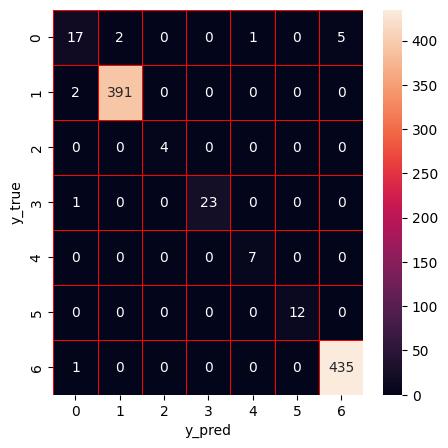

In [48]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [49]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9922308546059934
Precision of ET: 0.9927899039365308
Recall of ET: 0.9922308546059934
F1-score of ET: 0.9917538990459019
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        25
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.96      1.00      0.98        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.96      0.96      0.96       901
weighted avg       0.99      0.99      0.99       901



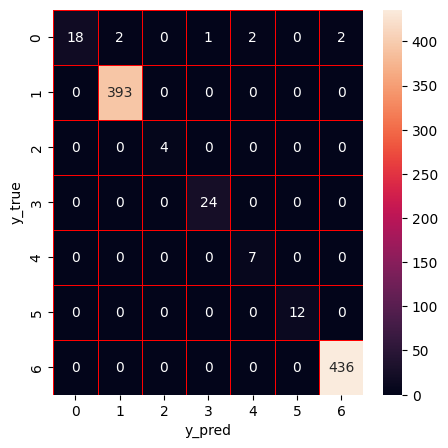

In [50]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [51]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:03<00:00,  6.46trial/s, best loss: -0.9866814650388457]
Random Forest: Hyperopt estimated optimum {'criterion': np.int64(0), 'max_depth': np.float64(41.0), 'max_features': np.float64(19.0), 'min_samples_leaf': np.float64(4.0), 'min_samples_split': np.float64(8.0), 'n_estimators': np.float64(112.0)}


Accuracy of ET: 0.9911209766925638
Precision of ET: 0.9916940112511243
Recall of ET: 0.9911209766925638
F1-score of ET: 0.9904342853177587
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        25
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.96      1.00      0.98        24
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.96      0.95      0.95       901
weighted avg       0.99      0.99      0.99       901



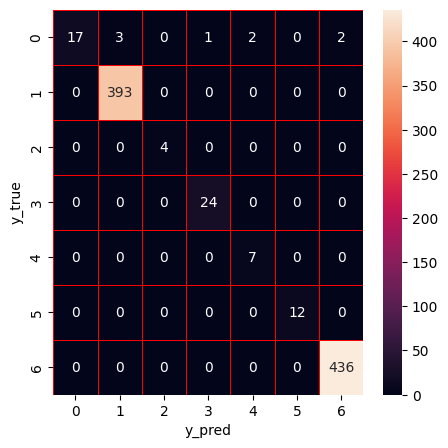

In [52]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [53]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [54]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,6,6,6,6
4,3,3,3,3


In [55]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [56]:
dt_train.shape

(5557, 1)

In [57]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9900110987791343
Precision of Stacking: 0.989959134338667
Recall of Stacking: 0.9900110987791343
F1-score of Stacking: 0.9897262498684261
              precision    recall  f1-score   support

           0       0.90      0.76      0.83        25
           1       0.99      0.99      0.99       393
           2       0.80      1.00      0.89         4
           3       0.96      0.96      0.96        24
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.93      0.96      0.94       901
weighted avg       0.99      0.99      0.99       901



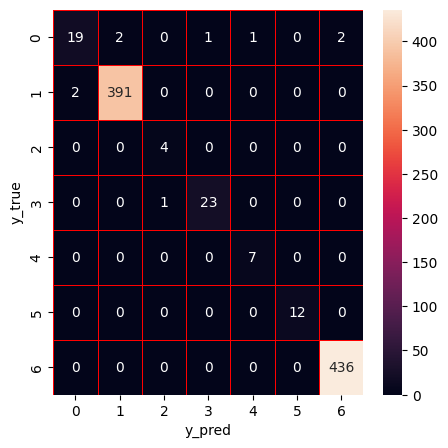

In [58]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [59]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:04<00:00,  4.53trial/s, best loss: -0.9933407325194229]
XGBoost: Hyperopt estimated optimum {'learning_rate': np.float64(-0.24445983040715394), 'max_depth': np.float64(87.0), 'n_estimators': np.float64(15.0)}


Accuracy of XGBoost: 0.9911209766925638
Precision of XGBoost: 0.9908914317859476
Recall of XGBoost: 0.9911209766925638
F1-score of XGBoost: 0.9907857931826071
              precision    recall  f1-score   support

           0       0.90      0.76      0.83        25
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00         4
           3       0.96      1.00      0.98        24
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       901
   macro avg       0.96      0.96      0.96       901
weighted avg       0.99      0.99      0.99       901



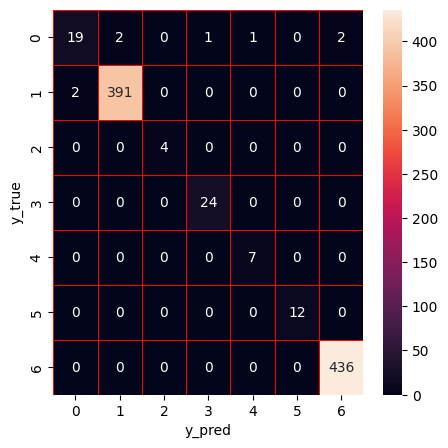

In [60]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [61]:
df=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [62]:
df.Label.value_counts()

Label
6    2180
1    1966
0     122
3     120
5      59
4      36
2      20
Name: count, dtype: int64

In [63]:
df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [64]:
df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [65]:
df1 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [66]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [67]:
df1.Label.value_counts()

Label
1    4322
0     122
Name: count, dtype: int64

In [68]:
df2.Label.value_counts()

Label
1    59
Name: count, dtype: int64

In [69]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [70]:
df2.Label.value_counts()

Label
1    59
0     8
Name: count, dtype: int64

In [71]:
#df = df1.append(df2)
df = pd.concat([df1, df2], ignore_index=True)

In [72]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4381
0     130
Name: count, dtype: int64

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [73]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [74]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [75]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [76]:
X_fs = df[fs].values

In [77]:
X_fs.shape

(4511, 41)

In [78]:
X_fs

array([[-1.23173956, -0.06319079, -0.06319079, ..., -0.21544492,
        -0.04062652,  4.69307149],
       [-1.25337689, -0.06684058, -0.06684058, ..., -0.08010518,
        -0.04067126, -0.75998859],
       [-0.60874187, -0.06747533, -0.06747533, ..., -0.21539983,
        -0.04049229, -0.5281689 ],
       ...,
       [-1.25337689, -0.0672373 , -0.0672373 , ..., -0.2148105 ,
         1.31654461, -0.73464979],
       [-1.2436991 , -0.06781915, -0.06781915, ..., -0.02063712,
        -0.03624176, -0.75998523],
       [-1.25337689, -0.06678769, -0.06678769, ..., -0.02910709,
        -0.04053703, -0.76001037]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [79]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [80]:
X_fss = fcbf.fit_transform(X_fs,y)

In [81]:
X_fss.shape

(4511, 20)

In [82]:
X_fss

array([[-0.32075246, -0.31975867, -0.2268941 , ...,  3.05338326,
        -0.03135585, -0.03135585],
       [ 7.1782786 ,  7.18163654,  7.03827468, ..., -0.14460493,
        -0.09060296, -0.09060296],
       [-0.32075246, -0.31975867, -0.2268941 , ...,  6.3131629 ,
        -0.0880818 , -0.0880818 ],
       ...,
       [ 8.5970142 ,  8.60081942,  4.1762385 , ..., -0.1665128 ,
        -0.1044693 , -0.1044693 ],
       [-0.32075246, -0.31975867, -0.2268941 , ..., -0.20021723,
        -0.10068757, -0.10068757],
       [ 7.58363163,  7.58711736,  8.50598555, ..., -0.13337012,
        -0.09060296, -0.09060296]])

####  kernel principal component analysis (KPCA)

In [83]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [84]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [85]:
pd.Series(y_train).value_counts()

1    4322
0     122
Name: count, dtype: int64

In [86]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [87]:
pd.Series(y_train).value_counts()

1    18225
0      122
Name: count, dtype: int64

In [88]:
pd.Series(y_test).value_counts()

1    59
0     8
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [89]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [90]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [91]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.94        59

    accuracy                           0.88        67
   macro avg       0.44      0.50      0.47        67
weighted avg       0.78      0.88      0.82        67

0.8805970149253731
[[ 0  8]
 [ 0 59]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [92]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.4925373134328358
43 0.4925373134328358
43 0.4925373134328358
43 0.4925373134328358
32 0.4925373134328358
20 0.4925373134328358
16 0.4925373134328358
5 0.8805970149253731
15 0.4925373134328358
25 0.4925373134328358
4 0.8805970149253731
2 0.8805970149253731
50 0.4925373134328358
7 0.4925373134328358
3 0.8805970149253731
37 0.4925373134328358
46 0.4925373134328358
11 0.8805970149253731
12 0.9253731343283582
8 0.4925373134328358
2.4293899536132812
Best score=0.9254
Best parameters: n_clusters=12


In [93]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

3 0.8805970149253731                                  
9 0.8805970149253731                                  
43 0.9402985074626866                                                            
8 0.8805970149253731                                                             
4 0.8805970149253731                                                             
25 0.4925373134328358                                                            
31 0.5373134328358209                                                            
36 0.8805970149253731                                                            
41 0.5373134328358209                                                            
8 0.8805970149253731                                                             
45 0.8955223880597015                                                             
37 0.4925373134328358                                                             
3 0.8805970149253731                                                

In [94]:
CL_kmeans(X_train, X_test, y_train, y_test, 16)

              precision    recall  f1-score   support

           0       0.04      0.12      0.06         8
           1       0.82      0.54      0.65        59

    accuracy                           0.49        67
   macro avg       0.43      0.33      0.35        67
weighted avg       0.73      0.49      0.58        67

0.4925373134328358
[[ 1  7]
 [27 32]]


### Apply the CL-k-means model with biased classifiers

In [95]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)

HMAC implementation may begin.

In [96]:
import pandas as pd  # type: ignore
import hmac
import hashlib

# Path to the CSV file
file_path = './data/CICIDS2017_sample.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)


In [97]:
benign_count = 0
attack_count = 0

for status in df['Label']:
    if status == 'BENIGN':
        benign_count += 1
    else:  
        attack_count += 1

Safe: 22731 
Attack detected: 33930


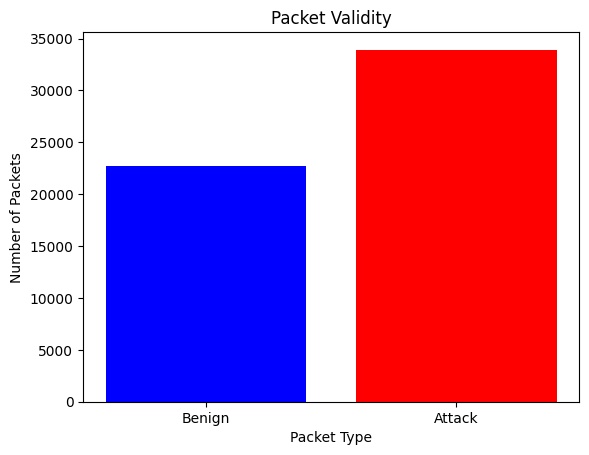

In [98]:
import matplotlib.pyplot as plt  # type: ignore

print(f'Safe: {benign_count} ')
print(f'Attack detected: {attack_count}')

packet_counts = {'Benign': benign_count, 'Attack': attack_count}

plt.bar(packet_counts.keys(), packet_counts.values(), color=['blue', 'red'])
plt.title("Packet Validity")
plt.xlabel("Packet Type")
plt.ylabel("Number of Packets")
plt.show()

All of the data in each row is encrypted into a key. This results in a secure hash-based message authentication code for every valid packet.

In [99]:
def applyhmac(row):
    #Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
    # data = f"{row['Active Min']}, {row['Idle Mean']}, {row['Idle Std']}, {row['Idle Max']}, {row['Idle Min']}, {row['Label']}".encode()
    data = ', '.join(map(str, row.values)).encode()
    secret_key= b'thisisthekey'
    hmac_result = hmac.new(secret_key, data, hashlib.sha256)

    return hmac_result.hexdigest()

If a packet is benign, the HMAC function will be applied.

In [100]:
df['HMAC'] = df.apply(lambda row: applyhmac(row) if row['Label'] == 'BENIGN' else "notvalid", axis=1)

In [101]:
df.to_csv('benign_with_hmac.csv', index=False)

In [102]:
df = pd.read_csv('benign_with_hmac.csv')
(df['HMAC'])

0        9bb18b548b6971c329a013ad8d2c9c76769e126c7e3b8c...
1        0b0c4a42e5f4a0f56b58b48ff796e05c377d697ccdddf6...
2        4954bbe87c8c7dfab285cb9b5f0cd18ed79eb4cc1c27b6...
3        b98cd48fbeb6f8cd734d425eba9dc848c884b17d7e9a47...
4        5c7b2d34fe1f12eb4818e35413c6b73e0b23898d96f41e...
                               ...                        
56656    ed85044a6ee7e9db52903373f9c7d8075f7a6f2844ba43...
56657    945dd7a3ab757d494d3c7edbbddfddc7b321e95648fe3e...
56658                                             notvalid
56659                                             notvalid
56660                                             notvalid
Name: HMAC, Length: 56661, dtype: object

In [103]:
hashed_count = 0
blocked = 0

for status in df['Label']:
    if status == 'BENIGN':
        hashed_count += 1
    else:  
        blocked += 1

Accepted Packets: 22731 
Blocked Packets: 33930


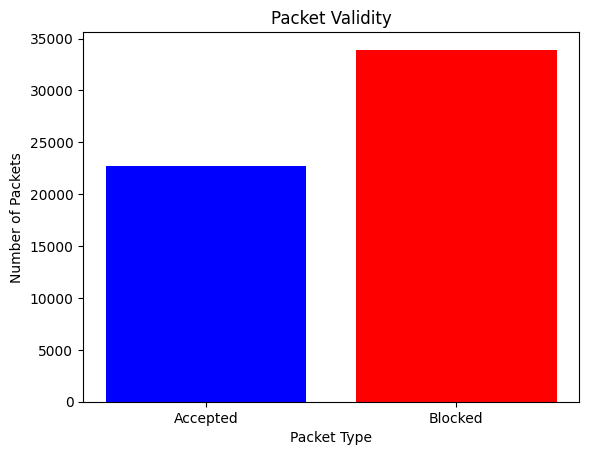

In [104]:
import matplotlib.pyplot as plt  # type: ignore

print(f'Accepted Packets: {hashed_count} ')
print(f'Blocked Packets: {blocked}')

packet_counts = {'Accepted': hashed_count, 'Blocked': blocked}

plt.bar(packet_counts.keys(), packet_counts.values(), color=['blue', 'red'])
plt.title("Packet Validity")
plt.xlabel("Packet Type")
plt.ylabel("Number of Packets")
plt.show()

In [105]:
# HMAC verification function
def verify_hmac(row, secret_key):
    
    data = ', '.join(map(str, row.drop(labels=['HMAC']).values)).encode()  
    # use the shared secret key
    computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()
    
    return computed_hmac == row['HMAC']

file_path = 'benign_with_hmac.csv'


In [106]:

# Read the file into a DataFrame
df = pd.read_csv(file_path)

# shared secret key
shared_key = b'thisisthekey'

# Apply the verification function 
df['Valid'] = df.apply(lambda row: verify_hmac(row, shared_key), axis=1)

# Save the verification results
output_file = 'verified_packets.csv'
df.to_csv(output_file, index=False)

# RESULTS 
valid_count = df['Valid'].sum()
invalid_count = len(df) - valid_count


In [107]:

print(f"Valid Packets: {valid_count}")
print(f"Invalid Packets: {invalid_count}")
print(f"Verification results saved to: {output_file}")


Valid Packets: 22731
Invalid Packets: 33930
Verification results saved to: verified_packets.csv


Simulation of all packets being sent and received

In [108]:
# creating array for unsafe addresses
unsafe_ips = []

In [109]:
import pandas as pd
import socket
import json

# UDP packet sender function
def send_all_packets(df, destination_ip, destination_port):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    
    # Counters for tracking sent packets
    valid_sent = 0
    invalid_blocked = 0

    for index, row in df.iterrows():
        packet = {
            "data": ', '.join(map(str, row.drop(labels=['HMAC']).values)),
            "Label": row['Label']
        }

        # Serialize packet to JSON
        packet_json = json.dumps(packet).encode()

        # Send packet
        sock.sendto(packet_json, (destination_ip, destination_port))

        # Update counters
        if row['Label'] == "BENIGN":
            valid_sent += 1
        else:
            invalid_blocked += 1

        # Report every 1000 packets
        if valid_sent % 1000 == 0 and row['Label'] == "BENIGN":
            print(f"{valid_sent} valid packets sent...")
        if invalid_blocked % 1000 == 0 and  row['Label'] != "BENIGN":
            print(f"{invalid_blocked} invalid packets sent...")   
    # Close socket
    sock.close()
    print("All packets sent.")
    print(f"Total valid packets sent: {valid_sent}")
    print(f"Total invalid packets sent: {invalid_blocked}")

# Configuration
file_path = '/Users/erikatorres/cs 4371 hmac/benign_with_hmac.csv'
shared_key = b'thisisthekey'
destination_ip = '127.0.0.1'
destination_port = 8080      

# Read and process the CSV file
df = pd.read_csv(file_path)

In [110]:
import pandas as pd
import socket
import json


# UDP packet receiver function
def receive_udp_packets(listening_ip, listening_port, secret_key):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((listening_ip, listening_port))
    print(f"Listening on {listening_ip}:{listening_port}")

    send_all_packets(df, destination_ip, destination_port)

    # Counter for packets
    counter = 0
    
    try:
        while True:
            # Receive packet
            packet_data, addr = sock.recvfrom(1024)  # Buffer size is 1024 bytes
            packet = json.loads(packet_data.decode())

            unsafe_ips.append(addr)

            if counter > 200:
                break
            
            else :
                print(f"Packet detected from {addr}: {packet['data']}")
                counter += 1

    finally:
        sock.close()

# Configuration
listening_ip = "127.0.0.1"
listening_port = 8080  # Match the sender's port
shared_key = b'thisisthekey'

# Start the receiver
receive_udp_packets(listening_ip, listening_port, shared_key)

Listening on 127.0.0.1:8080
1000 invalid packets sent...
2000 invalid packets sent...
3000 invalid packets sent...
4000 invalid packets sent...
5000 invalid packets sent...
6000 invalid packets sent...
1000 valid packets sent...
7000 invalid packets sent...
8000 invalid packets sent...
9000 invalid packets sent...
10000 invalid packets sent...
11000 invalid packets sent...
12000 invalid packets sent...
13000 invalid packets sent...
2000 valid packets sent...
14000 invalid packets sent...
3000 valid packets sent...
15000 invalid packets sent...
16000 invalid packets sent...
4000 valid packets sent...
5000 valid packets sent...
6000 valid packets sent...
7000 valid packets sent...
8000 valid packets sent...
9000 valid packets sent...
10000 valid packets sent...
11000 valid packets sent...
12000 valid packets sent...
17000 invalid packets sent...
18000 invalid packets sent...
13000 valid packets sent...
14000 valid packets sent...
19000 invalid packets sent...
20000 invalid packets sent..

Simulation of packets being sent with HMAC.

In [111]:
# creating array for safe ip addresses
safe_ips = []

In [112]:
import pandas as pd
import hmac
import hashlib
import socket
import json

# HMAC verification function
def verify_hmac(row, secret_key):
    data = ', '.join(map(str, row.drop(labels=['HMAC']).values)).encode()
    computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()
    return computed_hmac == row['HMAC']

# UDP packet sender function
def send_udp_packets(df, destination_ip, destination_port):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    
    # Counters for tracking sent packets
    valid_sent = 0
    invalid_blocked = 0

    for index, row in df.iterrows():
        packet = {
            "data": ', '.join(map(str, row.drop(labels=['Valid', 'HMAC']).values)),
            "HMAC": row['HMAC'],
            "Valid": row['Valid']
        }

        # Serialize packet to JSON
        packet_json = json.dumps(packet).encode()

        if row['Valid']:
            # Send packet
            sock.sendto(packet_json, (destination_ip, destination_port))

        # Update counters
        if row['Valid']:
            valid_sent += 1
            
        else:
            invalid_blocked += 1
            


        # Report every 1000 packets
        if valid_sent % 1000 == 0 and row['Valid']:
            print(f"{valid_sent} valid packets sent...")
        if invalid_blocked % 1000 == 0 and not row['Valid']:
            print(f"{invalid_blocked} invalid packets blocked...")   
    # Close socket
    sock.close()
    print("All packets sent.")
    print(f"Total valid packets sent: {valid_sent}")
    print(f"Total invalid packets blocked: {invalid_blocked}")

# Configuration
file_path = 'benign_with_hmac.csv'
shared_key = b'thisisthekey'
destination_ip = '127.0.0.1'
destination_port = 8080      

# Read and process the CSV file
df = pd.read_csv(file_path)
df['Valid'] = df.apply(lambda row: verify_hmac(row, shared_key), axis=1)


In [113]:
import socket

# HMAC verification function
def verify_hmac(packet, secret_key):
    try:
        # Extract data and HMAC from the packet
        data = packet["data"].encode()  # Data is already a string
        hmac_received = packet["HMAC"]

        # Compute HMAC using the shared secret key
        computed_hmac = hmac.new(secret_key, data, hashlib.sha256).hexdigest()

        # Check if the packet is valid (HMAC matches and "Valid" flag is True)
        return packet["Valid"] and computed_hmac == hmac_received
    except Exception as e:
        print(f"Error verifying HMAC: {e}")
        return False

# UDP packet receiver function
def receive_udp_packets(listening_ip, listening_port, secret_key):
    # Create a UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind((listening_ip, listening_port))
    print(f"Listening on {listening_ip}:{listening_port}")


    send_udp_packets(df, destination_ip, destination_port)

    # Counter for invalid packets
    invalid_packets = 0
    valid = 0

    try:
        while True:
            # Receive packet
            packet_data, addr = sock.recvfrom(1024)  # Buffer size is 1024 bytes
            packet = json.loads(packet_data.decode())

            if valid > 150:
                break

            # Verify packet validity
            if verify_hmac(packet, secret_key):
                print(f"Valid packet received from {addr}: {packet['data']}")
                valid += 1
                safe_ips.append(addr)

            else:
                print(f"Invalid packet detected from {addr}: {packet['data']}")
                invalid_packets += 1

            # Output the count of invalid packets if any are detected
            if invalid_packets > 0:
                print(f"Invalid packets that have slipped in: {invalid_packets}")

    except KeyboardInterrupt:
        print("Receiver terminated by user.")
    finally:
        if invalid_packets == 0:
            print("No invalid packets were transfered")
        sock.close()

# Configuration
listening_ip = "127.0.0.1"
listening_port = 8080  # Match the sender's port
shared_key = b'thisisthekey'

# Start the receiver
receive_udp_packets(listening_ip, listening_port, shared_key)

Listening on 127.0.0.1:8080
1000 invalid packets blocked...
2000 invalid packets blocked...
3000 invalid packets blocked...
4000 invalid packets blocked...
5000 invalid packets blocked...
6000 invalid packets blocked...
1000 valid packets sent...
7000 invalid packets blocked...
8000 invalid packets blocked...
9000 invalid packets blocked...
10000 invalid packets blocked...
11000 invalid packets blocked...
12000 invalid packets blocked...
13000 invalid packets blocked...
2000 valid packets sent...
14000 invalid packets blocked...
3000 valid packets sent...
15000 invalid packets blocked...
16000 invalid packets blocked...
4000 valid packets sent...
5000 valid packets sent...
6000 valid packets sent...
7000 valid packets sent...
8000 valid packets sent...
9000 valid packets sent...
10000 valid packets sent...
11000 valid packets sent...
12000 valid packets sent...
17000 invalid packets blocked...
18000 invalid packets blocked...
13000 valid packets sent...
14000 valid packets sent...
1900

In [114]:
# Asking user for input.
# exit = exits the program
# safe = shows safe addresses
# unsafe + shows addresses where attacks were detected

while True:
    user_input = input("Exit or show addresses ('safe' or 'unsafe')? ").strip()
    
    if user_input.lower() == 'exit':
        print("Exiting program.")
        break
    elif user_input.lower() == 'safe':
        print("Safe addresses (first 150):")
        print(safe_ips[:150])
    elif user_input.lower() == 'unsafe':
        print("Unsafe addresses (first 150):")
        print(unsafe_ips[:150])
    else:
        print("Invalid choice. Please type 'safe', 'unsafe', or 'exit'.")

Safe addresses (first 150):
[('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('127.0.0.1', 64744), ('1